# Model Evaluation & Validation: The Error

## Overview

<style>
    table.custom-table {
        max-width: 1000px;
        width: 100%;
        margin: 0 auto; /* centers the table on the page */
    }

    table.custom-table td {
        background-color: #fff;
    }
    
    table.custom-table th, table.custom-table td {
        text-align: center;
        vertical-align: middle;
        padding: 5px;
        width: 500px; /* distribute the total width equally among three columns */
    }

    table.custom-table img {
        width: 100%;
        display: block; /* removes any gap under the image */
    }
</style>


<table class="custom-table">
    <thead>
        <tr>
            <th>Output: Prediction vs. Real Data (Error)</th>
            <th>Output: The Error Interpretation</th>
            <th>Input: Prediction Table</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>
                <img src="src/01_output_1.png">
            </td>
            <td>
                <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/8c/Standard_deviation_diagram.svg/1280px-Standard_deviation_diagram.svg.png">
            </td>
            <td>
                <img src="src/01_output_2.png">
            </td>
        </tr>
    </tbody>
</table>

## Data

In [1]:
#!

import pandas as pd

df_passengers = pd.read_csv('../../../data/airline-passengers.csv', parse_dates=["Month"], index_col="Month")
data = df_passengers.asfreq('MS')['Passengers']
data

Month
1949-01-01    112
1949-02-01    118
             ... 
1960-11-01    390
1960-12-01    432
Freq: MS, Name: Passengers, Length: 144, dtype: int64

## Modelling

### Fit the Model

In [2]:
from statsmodels.tsa.arima.model import ARIMA #!

model = ARIMA(data, order=(0, 1, 2), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit()

### Forecast: Calculate Predictions

In [3]:
y_pred = model_fit.predict()
y_pred

Month
1949-01-01      0.000000
1949-02-01    111.997328
                 ...    
1960-11-01    414.883634
1960-12-01    439.947772
Freq: MS, Name: predicted_mean, Length: 144, dtype: float64

### Model's Score: Predictions vs Reality

In [4]:
error = data[1:] - y_pred[1:] #!
error2 = error**2
MSE = error2.mean()
RMSE = MSE**0.5
RMSE

12.487395495743867

#### Step by Step

In [5]:
df_pred = (df_passengers
.assign(Predicted=y_pred)
.iloc[1:])

df_pred

,Passengers,Predicted
Month,,
1949-02-01,118,111.997328
1949-03-01,132,117.999752
...,...,...
1960-11-01,390,414.883634
1960-12-01,432,439.947772


In [6]:
#r

import dataframe_image as dfi
dfi.export(df_pred, 'src/01_input.png', max_rows=4, dpi=200)

In [7]:
df_pred['error'] = df_pred['Passengers'] - df_pred['Predicted']
df_pred

,Passengers,Predicted,error
Month,,,
1949-02-01,118,111.997328,6.002672
1949-03-01,132,117.999752,14.000248
...,...,...,...
1960-11-01,390,414.883634,-24.883634
1960-12-01,432,439.947772,-7.947772


In [8]:
df_pred.error.mean()

-0.01577236767447063

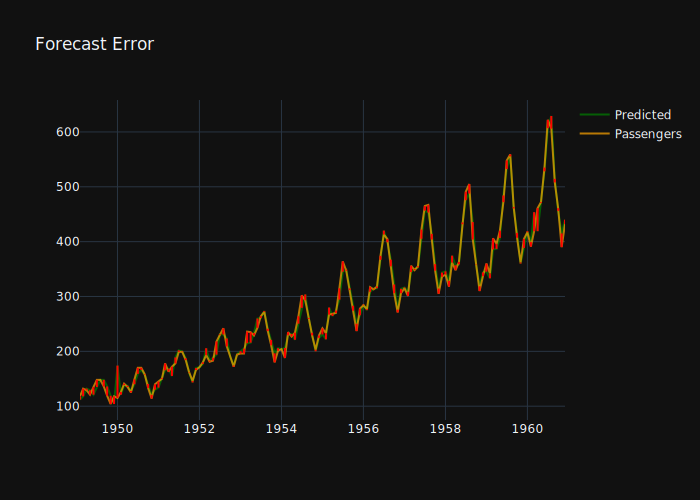

In [9]:
#r
import sys
sys.path.append('../')

import utils
utils.draw_error(df_pred, 'Predicted', 'Passengers')

In [10]:
#r

fig = utils.draw_error(df_pred.loc['1960':], 'Predicted', 'Passengers')
fig.write_image('src/01_output_1.png', width=800*1.2, height=400*1.2)

In [11]:
df_pred['error2'] = df_pred['error']**2
df_pred

,Passengers,Predicted,error,error2
Month,,,,
1949-02-01,118,111.997328,6.002672,36.032066
1949-03-01,132,117.999752,14.000248,196.006936
...,...,...,...,...
1960-11-01,390,414.883634,-24.883634,619.195244
1960-12-01,432,439.947772,-7.947772,63.167075


In [12]:
#r

import dataframe_image as dfi
dfi.export(df_pred, 'src/01_output_2.png', max_rows=4, dpi=200)

In [13]:
MSE = df_pred.error2.mean()
MSE

155.9350462671242

155k passengers of error?

In [14]:
RMSE = MSE**0.5
RMSE

12.487395495743867

<Axes: >

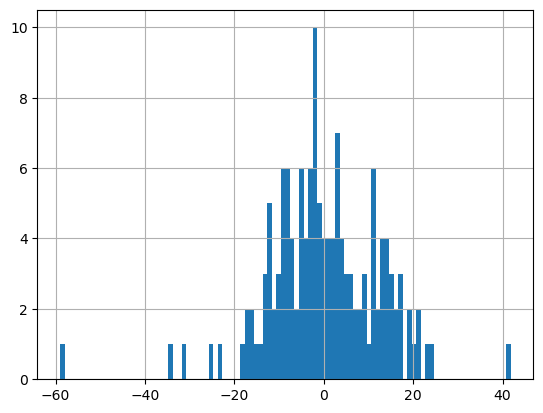

In [15]:
df_pred.error.hist(bins=100)

![](https://upload.wikimedia.org/wikipedia/commons/thumb/8/8c/Standard_deviation_diagram.svg/1280px-Standard_deviation_diagram.svg.png)

## Other Error Measures

Time series forecasting and analysis often require error measures to evaluate the accuracy of models and predictions.

1. **Mean Absolute Error (MAE)**:
    $$ MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i| $$
   Where $y_i$ is the actual value, $\hat{y}_i$ is the predicted value, and $n$ is the number of observations. It gives an idea of the magnitude of the error but doesn't consider the direction.

2. **Mean Squared Error (MSE)**:
    $$ MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 $$
   It gives more weight to larger errors due to the squaring.

3. **Root Mean Squared Error (RMSE)**:
    $$ RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2} $$
   RMSE is the square root of MSE, making it more interpretable in the same units as the original data.

4. **Mean Absolute Percentage Error (MAPE)**:
    $$ MAPE = \frac{100\%}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right| $$
   It gives the error as a percentage, which can be useful for comparing accuracy across different datasets or scales. However, it's undefined when $y_i = 0$.

5. **Symmetric Mean Absolute Percentage Error (sMAPE)**:
    $$ sMAPE = \frac{100\%}{n} \sum_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{(|y_i| + |\hat{y}_i|)/2} $$
   An alternative to MAPE that handles zeros and negative values better.

6. **Mean Bias Deviation (MBD)**:
    $$ MBD = \frac{100\%}{n} \sum_{i=1}^{n} \frac{y_i - \hat{y}_i}{y_i} $$
   It measures the bias in the predictions.

7. **Mean Absolute Scaled Error (MASE)**:
    $$ MASE = \frac{\sum_{i=1}^{n} |y_i - \hat{y}_i|}{\sum_{i=1}^{n} |y_i - y_{i-1}|} $$
   It compares the forecast errors to the errors of a naïve benchmark prediction, usually the naïve forecast (where each forecast is equal to the last observed value).

8. **R-squared**:
   It represents the proportion of variance in the dependent variable that is predictable from the independent variable(s). It's a measure of how well the regression predictions approximate the real data points.

9. **AIC (Akaike Information Criterion)** and **BIC (Bayesian Information Criterion)**:
   While these are not direct error measures, they are often used in time series modeling to compare the goodness of fit of models, taking into account the number of parameters used.

10. **Theil’s U-statistic**:
    It's a relative measure comparing the forecast error to the naive forecast's error and the change in the actual series. A value of 1 indicates the forecast is as accurate as a naive forecast; less than 1 indicates it's more accurate.

11. **Diebold-Mariano Test**:
    A statistical test used to compare the predictive accuracy of two forecasting methods.

Choosing the right error measure depends on the specific application, the nature of the data, and the goals of the analysis. Some measures may be more appropriate for certain datasets or problems than others.

You can calculate most of these error measures using Python, especially with the help of libraries like `numpy`, `pandas`, and `sklearn`. Here's a brief overview of how to implement or import some of them:

1. **Mean Absolute Error (MAE)**:
    ```python
    from sklearn.metrics import mean_absolute_error
    ```

2. **Mean Squared Error (MSE)**:
    ```python
    from sklearn.metrics import mean_squared_error
    ```

3. **Root Mean Squared Error (RMSE)**:
    Using `mean_squared_error` with an additional square root:
    ```python
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    ```

4. **Mean Absolute Percentage Error (MAPE)**:
    This isn't directly available in `sklearn`, but you can easily define it:
    ```python
    def mape(actual, predicted):
        return np.mean(np.abs((actual - predicted) / actual)) * 100
    ```

5. **Symmetric Mean Absolute Percentage Error (sMAPE)**:
    Similarly, you might have to define it:
    ```python
    def smape(actual, predicted):
        return 100*np.mean(2*np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))
    ```

6. **Mean Absolute Scaled Error (MASE)**:
    Not available in `sklearn`. Here's a custom function:
    ```python
    def mase(actual, predicted):
        n = len(actual)
        d = np.abs(np.diff(actual)).sum()/(n-1)
        errors = np.abs(actual - predicted)
        return errors.mean()/d
    ```

7. **R-squared**:
    ```python
    from sklearn.metrics import r2_score
    ```

8. **AIC (Akaike Information Criterion)** and **BIC (Bayesian Information Criterion)**:
    If you're using statsmodels for time series modeling (like ARIMA), these are usually available in the model's summary:
    ```python
    from statsmodels.tsa.arima.model import ARIMA
    model = ARIMA(...)
    results = model.fit()
    print(results.aic, results.bic)
    ```

9. **Theil’s U-statistic** and **Diebold-Mariano Test**:
    These aren't directly available in common libraries like `sklearn` or `statsmodels`, and you might need to write custom functions or seek specialized packages or scripts.

For more complex or less common error measures, it's possible that specialized libraries or manual implementations are necessary. Always ensure you understand the calculations and potential pitfalls of any metric you're using, especially if you're implementing them manually.